In [1]:
# add path to sispeuede to sys.path in python
import sys
import warnings
dir_git = "/Users/usuario/git/sisepuede"
if dir_git not in sys.path:
    sys.path.append(dir_git)


warnings.filterwarnings("ignore")

import logging
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import sisepuede as si
import sisepuede.core.attribute_table as att
import sisepuede.core.model_attributes as ma
import sisepuede.core.model_variable as mv
import sisepuede.core.support_classes as sc
import sisepuede.manager.sisepuede_examples as sxm
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.transformers as trf
import sisepuede.utilities._toolbox as sf
import time
from typing import *

# hack for now
log_job = None



# Setup the file structure and read in data

In [2]:
struct = sfs.SISEPUEDEFileStructure()
examples = sxm.SISEPUEDEExamples()

matt = struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

# directories
path_cur = pathlib.Path(os.getcwd())
path_data = path_cur.joinpath("data")
path_transformations = path_cur.joinpath("transformations")
if not path_transformations.exists():
    path_transformations.mkdir(exist_ok = True, )

# file paths
fp_inputs = path_data.joinpath("louisiana_inputs_raw.csv")#joinpath("louisiana_working_data_20240826", "MODEL_INPUTS.csv")



##  Format input data

In [245]:
# read in default data
regions_run = ["louisiana"]

df_inputs_base_la = pd.read_csv(fp_inputs, )
df_input = df_inputs_base_la.copy()


# overwrite some variables
for mvname in ["Agriculture Equivalent Exports", "Livestock Equivalent Exports"]:
    modvar = matt.get_variable(mvname)
    if modvar is None:
        raise RuntimeError(f"Error: model variable '{mvname}' not found.")
    df_input[modvar.fields] = 0


# filter
field_region = regions.key
regions_run = [
    x for x in regions_run if x in list(df_input[field_region].unique())
]

# reduce inputs
df_input = (
    df_input[
        df_input[field_region].isin(regions_run)
    ]
    #.drop(columns = [matt.dim_primary_id])
    .reset_index(drop = True)
)




###  Secondary attempt - run if everything is built

In [6]:

df_input = pd.read_csv(path_data.joinpath("louisiana_inputs_raw.csv"))


# build transformations

In [528]:
transformers = trf.Transformers(
    {},
    df_input = df_input,
)

if not path_transformations.exists():
    
    print("BUILDING DEFAULT TRANSFORMATIONS")
    
    trf.instantiate_default_strategy_directory(
        transformers,
        path_transformations,
    )


# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    path_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table


# build strategies
import sisepuede.transformers.strategies as sts
importlib.reload(sts)
#  build the strategies -- will export to path
t0 = time.time()
strategies = sts.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

# build whirlpool with existing data
# tss = strategies.build_whirlpool_strategies(6004, ids = list(range(7101, 7160)))


##  GET XL SPECIFICATIONS AND SAMPLE GROUPS

# base off of the LA strat
strat = strategies.get_strategy(6004)

transformations_include = strat.get_transformation_list(
    strat.transformation_specification,
    transformations,
)

_FIELD_VARIABLE = "variable"
_FIELD_VARIABLE_TRAJECTORY_GROUP = "variable_trajectory_group"

df_transformation_code_to_varchange = transformations.get_transformations_variable_fields(
    transformations_include = transformations_include,
    include_all_variable_fields_by_modvar = False, 
    include_sample_group = True,
    field_sample_group = _FIELD_VARIABLE_TRAJECTORY_GROUP,
    field_variable = _FIELD_VARIABLE,
)





Strategies defined at /Users/usuario/git/sisepuede_region_nbs/louisiana/transformations initialized in 2.47 seconds


# Build uncertainty ranges that we want for an experiment
- initialize `_GROUP_IND_UNCERTAINTY` iterator below

In [422]:
_DF_UNCERTAINTY = []
_GROUP_IND_UNCERTAINTY = 1


tp_max = max(time_periods.all_time_periods)

_FIELD_MAX = f"max_{tp_max}"
_FIELD_MIN = f"min_{tp_max}"
_FIELD_TRAJGROUP = strategies.input_template.field_req_variable_trajectory_group
_FIELD_VARIABLE = strategies.input_template.field_req_variable



##  Build uncertainties for fuel prices

In [423]:

_CATS_ENFU_FF = [
    "fuel_coal",
    "fuel_coke",
    "fuel_crude",
    "fuel_diesel",
    "fuel_gasoline",
    "fuel_hydrocarbon_gas_liquids",
    "fuel_kerosene",
    "fuel_natural_gas",
    "fuel_oil"
]
scalar_range = (0.5, 1.8)


# variables to tie into groups
modvar_fuel_price_gravimetric = matt.get_variable("Gravimetric Fuel Price")
modvar_fuel_price_thermal = matt.get_variable("Thermal Fuel Price")
modvar_fuel_price_volumetric = matt.get_variable("Volumetric Fuel Price")
modvars = [
    modvar_fuel_price_gravimetric,
    modvar_fuel_price_thermal,
    modvar_fuel_price_volumetric
]

fields_combine = []
for mv in modvars:
    fields_combine += mv.build_fields(
        category_restrictions = _CATS_ENFU_FF
    )


df_component = pd.DataFrame(
    {
        _FIELD_VARIABLE: fields_combine,
        _FIELD_MAX: [scalar_range[1] for x in fields_combine],
        _FIELD_MIN: [scalar_range[0] for x in fields_combine],
        _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
    }
)

_DF_UNCERTAINTY.append(df_component)
_GROUP_IND_UNCERTAINTY += 1
df_component


,variable,max_35,min_35,variable_trajectory_group
0,cost_enfu_fuel_coal_usd_per_tonne,1.8,0.5,1
1,cost_enfu_fuel_coke_usd_per_tonne,1.8,0.5,1
2,cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per...,1.8,0.5,1
3,cost_enfu_fuel_natural_gas_usd_per_mmbtu,1.8,0.5,1
4,cost_enfu_fuel_crude_usd_per_m3,1.8,0.5,1
5,cost_enfu_fuel_diesel_usd_per_m3,1.8,0.5,1
6,cost_enfu_fuel_gasoline_usd_per_m3,1.8,0.5,1
7,cost_enfu_fuel_kerosene_usd_per_m3,1.8,0.5,1
8,cost_enfu_fuel_oil_usd_per_m3,1.8,0.5,1


In [424]:
'/Users/usuario/Desktop/attributes'

'/Users/usuario/Desktop/attributes'

## Build uncertainties for power techs

In [425]:

dict_tech_classes = transformers.model_enerprod.get_tech_info_dict()
_CATS_ETNC_PP = dict_tech_classes.get("all_techs_pp")

groups = [
    [
        "pp_coal",
        "pp_coal_ccs",
        "pp_gas",
        "pp_gas_ccs",
        "pp_oil"
    ],
    [
        "pp_nuclear"
    ]
]

scalar_ranges = [(0.5, 1.5), (0.5, 2.0)]


# variables to tie into groups
modvar_capex = matt.get_variable("NemoMod CapitalCost")

for i, grp in enumerate(groups):
    ranges = scalar_ranges[i]
    fields_combine = modvar_capex.build_fields(category_restrictions = grp, )
    
    
    df_component = pd.DataFrame(
        {
            _FIELD_VARIABLE: fields_combine,
            _FIELD_MAX: [ranges[1] for x in fields_combine],
            _FIELD_MIN: [ranges[0] for x in fields_combine],
            _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
        }
    )

    _DF_UNCERTAINTY.append(df_component)
    _GROUP_IND_UNCERTAINTY += 1


df_component

,variable,max_35,min_35,variable_trajectory_group
0,nemomod_entc_capital_cost_pp_nuclear_mm_usd_pe...,2.0,0.5,3


##  Build uncertainties for energy storage

In [426]:

# variables to tie into groups
modvar_capex = matt.get_variable("NemoMod CapitalCostStorage")
ranges = (0.8, 1.2)
fields_combine = modvar_capex.fields#build_fields(category_restrictions = grp, )


df_component = pd.DataFrame(
    {
        _FIELD_VARIABLE: fields_combine,
        _FIELD_MAX: [ranges[1] for x in fields_combine],
        _FIELD_MIN: [ranges[0] for x in fields_combine],
        _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
    }
)

_DF_UNCERTAINTY.append(df_component)
_GROUP_IND_UNCERTAINTY += 1


df_component

,variable,max_35,min_35,variable_trajectory_group
0,nemomod_enst_capital_cost_st_batteries_usd_per...,1.2,0.8,4
1,nemomod_enst_capital_cost_st_compressed_air_us...,1.2,0.8,4
2,nemomod_enst_capital_cost_st_flywheels_usd_per...,1.2,0.8,4
3,nemomod_enst_capital_cost_st_pumped_hydro_usd_...,1.2,0.8,4


In [427]:
_GROUP_IND_UNCERTAINTY


5

##  Build uncertainties for fuel exports

In [428]:

scalar_ranges = (0.8, 1.5)


# variables to tie into groups
modvar_capex = matt.get_variable("Fuel Exports")
ranges = scalar_ranges
fields_combine = modvar_capex.fields#build_fields(category_restrictions = grp, )


df_component = pd.DataFrame(
    {
        _FIELD_VARIABLE: fields_combine,
        _FIELD_MAX: [ranges[1] for x in fields_combine],
        _FIELD_MIN: [ranges[0] for x in fields_combine],
        _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
    }
)

_DF_UNCERTAINTY.append(df_component)
_GROUP_IND_UNCERTAINTY += 1


df_component

,variable,max_35,min_35,variable_trajectory_group
0,exports_enfu_pj_fuel_ammonia,1.5,0.8,5
1,exports_enfu_pj_fuel_coal,1.5,0.8,5
2,exports_enfu_pj_fuel_crude,1.5,0.8,5
3,exports_enfu_pj_fuel_diesel,1.5,0.8,5
4,exports_enfu_pj_fuel_electricity,1.5,0.8,5
5,exports_enfu_pj_fuel_gasoline,1.5,0.8,5
6,exports_enfu_pj_fuel_hydrocarbon_gas_liquids,1.5,0.8,5
7,exports_enfu_pj_fuel_hydrogen,1.5,0.8,5
8,exports_enfu_pj_fuel_kerosene,1.5,0.8,5
9,exports_enfu_pj_fuel_natural_gas,1.5,0.8,5


##  Build Uncertainties for GDP

In [429]:

scalar_ranges = (0.9, 1.1)


# variables to tie into groups
modvar_capex = matt.get_variable("GDP")
ranges = scalar_ranges
fields_combine = modvar_capex.fields#build_fields(category_restrictions = grp, )


df_component = pd.DataFrame(
    {
        _FIELD_VARIABLE: fields_combine,
        _FIELD_MAX: [ranges[1] for x in fields_combine],
        _FIELD_MIN: [ranges[0] for x in fields_combine],
        _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
    }
)

_DF_UNCERTAINTY.append(df_component)
_GROUP_IND_UNCERTAINTY += 1


df_component

,variable,max_35,min_35,variable_trajectory_group
0,gdp_mmm_usd,1.1,0.9,6


In [545]:
_DF_UNCERTAINTY

,variable,max_35,min_35,variable_trajectory_group
0,cost_enfu_fuel_coal_usd_per_tonne,1.800,0.500,1
1,cost_enfu_fuel_coke_usd_per_tonne,1.800,0.500,1
2,cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per...,1.800,0.500,1
3,cost_enfu_fuel_natural_gas_usd_per_mmbtu,1.800,0.500,1
4,cost_enfu_fuel_crude_usd_per_m3,1.800,0.500,1
5,cost_enfu_fuel_diesel_usd_per_m3,1.800,0.500,1
6,cost_enfu_fuel_gasoline_usd_per_m3,1.800,0.500,1
7,cost_enfu_fuel_kerosene_usd_per_m3,1.800,0.500,1
8,cost_enfu_fuel_oil_usd_per_m3,1.800,0.500,1
9,nemomod_entc_capital_cost_pp_coal_mm_usd_per_gw,1.500,0.500,2


##  Build uncertainties for population

In [430]:

scalar_ranges = (0.925, 1.075)


# variables to tie into groups
modvar_capex = matt.get_variable("Population")
ranges = scalar_ranges
fields_combine = modvar_capex.fields#build_fields(category_restrictions = grp, )


df_component = pd.DataFrame(
    {
        _FIELD_VARIABLE: fields_combine,
        _FIELD_MAX: [ranges[1] for x in fields_combine],
        _FIELD_MIN: [ranges[0] for x in fields_combine],
        _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
    }
)

_DF_UNCERTAINTY.append(df_component)
_GROUP_IND_UNCERTAINTY += 1


df_component

,variable,max_35,min_35,variable_trajectory_group
0,population_gnrl_rural,1.075,0.925,7
1,population_gnrl_urban,1.075,0.925,7


##  Build uncertainties for SCOE elasticities

In [431]:
modvars = [
    "SCOE Elasticity of Per GDP Electrical Applicance Demand to GDP Per Capita",
    "SCOE Elasticity of Per GDP Heat Energy Demand to GDP Per Capita",
	"SCOE Elasticity of Per Household Electrical Applicance Demand to GDP Per Capita",
	"SCOE Elasticity of Per Household Heat Energy Demand to GDP Per Capita"
]



scalar_ranges = (0.75, 1.25)


# variables to tie into groups

for x in modvars:
    modvar = matt.get_variable(x)
    ranges = scalar_ranges
    fields_combine = modvar.fields#build_fields(category_restrictions = grp, )
    
    
    df_component = pd.DataFrame(
        {
            _FIELD_VARIABLE: fields_combine,
            _FIELD_MAX: [ranges[1] for x in fields_combine],
            _FIELD_MIN: [ranges[0] for x in fields_combine],
            _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
        }
    )

    _DF_UNCERTAINTY.append(df_component)

_GROUP_IND_UNCERTAINTY += 1



##  Build uncertainties for Transportation Elasticities

In [432]:
modvars = [
    "Elasticity of Megatonne-Kilometer Demand to GDP",
    "Elasticity of Passenger-Kilometer Demand per Capita to GDP per Capita"
]



scalar_ranges = (0.75, 1.25)


# variables to tie into groups

for x in modvars:
    modvar = matt.get_variable(x)
    ranges = scalar_ranges
    fields_combine = modvar.fields#build_fields(category_restrictions = grp, )
    
    
    df_component = pd.DataFrame(
        {
            _FIELD_VARIABLE: fields_combine,
            _FIELD_MAX: [ranges[1] for x in fields_combine],
            _FIELD_MIN: [ranges[0] for x in fields_combine],
            _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
        }
    )

    # inentionally separate the groupings
    _DF_UNCERTAINTY.append(df_component)
    _GROUP_IND_UNCERTAINTY += 1



##  Build uncertainties for INEN Elasticities

In [433]:
modvars = [
    "Elasticity of Industrial Production to GDP",
    "Elasticity of Product Use Rate to GDP per Capita",
]



scalar_ranges = (0.75, 1.25)


# variables to tie into groups

for x in modvars:
    modvar = matt.get_variable(x)
    ranges = scalar_ranges
    fields_combine = modvar.fields
    
    
    df_component = pd.DataFrame(
        {
            _FIELD_VARIABLE: fields_combine,
            _FIELD_MAX: [ranges[1] for x in fields_combine],
            _FIELD_MIN: [ranges[0] for x in fields_combine],
            _FIELD_TRAJGROUP: [_GROUP_IND_UNCERTAINTY for x in fields_combine],
        }
    )

    _DF_UNCERTAINTY.append(df_component)
    _GROUP_IND_UNCERTAINTY += 1



In [434]:
_DF_UNCERTAINTY = sf._concat_df(_DF_UNCERTAINTY)

##  Build the `trajgroups` input

In [435]:
df_trajgroups = (
    df_transformation_code_to_varchange
    .get(
        [
            "variable_field",
            _FIELD_TRAJGROUP
        ]
    )
    .copy()
    .drop_duplicates()
    .reset_index(drop = True, )
    .rename(columns = {"variable_field": _FIELD_VARIABLE, })
)

df_uncertainty_component = _DF_UNCERTAINTY[[_FIELD_VARIABLE, _FIELD_TRAJGROUP]]
df_uncertainty_component[_FIELD_TRAJGROUP] += df_trajgroups[_FIELD_TRAJGROUP].max()

# check that there are no overlapping fields
shared_vfs = set(df_trajgroups[_FIELD_VARIABLE]) & set(df_uncertainty_component[_FIELD_VARIABLE])
if len(shared_vfs) > 0:
    raise RuntimeError("Cannot have overlapping fields in this merge")

df_trajgroups = sf._concat_df(
    [
        df_trajgroups,
        df_uncertainty_component,
    ]
)



In [444]:
path_out = pathlib.Path("/Users/usuario/Documents/Projects/Louisiana/experiments/attributes_and_info/sisepuede_run_2025-08-10t10;29;30.545790")
if not path_out.is_dir():
    path_out.mkdir(exist_ok = True, )
    
df_transformation_code_to_varchange.to_csv(
    path_out.joinpath("VARIABLE_TRAJECTORY_GROUPS_L.csv"),
    index = None,
    encoding = "UTF-8",
)

df_uncertainty_component.to_csv(
    path_out.joinpath("VARIABLE_TRAJECTORY_GROUPS_X.csv"),
    index = None,
    encoding = "UTF-8",
)

# START--build low implementation strategy configs

In [474]:
strat = strategies.get_strategy(6004)
transformations_list_all_la = strat.get_transformation_list(
    strat.transformation_specification,
    strategies.transformations,
)



In [507]:
def copy_to_medium_intensity(
    transformations: 'Transformations',
    all_codes: List[str],
    export: bool = False,
    key_magnitude: str = "magnitude",
    key_tp0: str = "tp_0_ramp",
    key_vir: str = "vec_implementation_ramp",
    verbose: bool = True,
) -> None:
    """Copy NDC transformations to NDC 2.0 with time starting in 2020
    """
    paths_transformations_cur = transformations.dict_paths.get(
        transformations.key_path_transformations, 
    )

    all_codes_out = []

    # iterate over each path
    for path in paths_transformations_cur:

        # get and check the code associated with this YAML
        transformation = trf.Transformation(
            path,
            transformations.transformers,
        )
        
        # skip any non-ndc transformations
        if transformation.code not in all_codes:
            continue


        ##  SET OUTPUT PATH AND EXPORT
        
        path_out = path.stem
        append = "_MIDINTENS"
        path_out = f"{path_out}{append}{path.suffix}"
        path_out = path.parents[0].joinpath(path_out)
        

        ##  UPDATE YAML - START WITH MAGNITUDE
            
        # get the parameters and update the start time
        dict_yaml = sf.read_yaml(path, munchify_dict = False, )
        dict_params = dict_yaml.get(transformation.key_parameters, )

        # get the magnitude from parameters and update as necessary
        mag = dict_params.get(key_magnitude)
        if mag is not None:
            dict_params.update({key_magnitude: mag/2, })
            if verbose: print(f"{transformation.code} magnitude updated successfully.")

        elif verbose: 
            print(f"\tNO MAGNITUDE: check {transformation.code} at '{path_out}'")
 
        dict_yaml.update({transformation.key_parameters: dict_params, })


        ##  UPDATE IDENTIFICATION INFO
        
        dict_ids = dict_yaml.get(transformation.key_identifiers, )

        # update the code
        code = dict_ids.get(transformation.key_transformation_code, )
        code = f"{code}{append}"
        dict_ids.update({transformation.key_transformation_code: code, })

        # update the name
        name = dict_ids.get(transformation.key_transformation_name, )
        name = f"{name} at medium intensity for jobs run"
        dict_ids.update({transformation.key_transformation_name: name, })

        dict_yaml.update({transformation.key_identifiers: dict_ids, })

        
        
        # write output?
        if export: sf._write_yaml(dict_yaml, path_out, )

        # finally, add to all codes to build new strategy
        all_codes_out.append(code)

    
    all_codes_out.sort()

    return all_codes_out





# already exported, no need to do it again at the moment
all_codes_mid = copy_to_medium_intensity(
    transformations, 
    [x.code for x in transformations_list_all_la],
    export = False, 
    verbose = False,
);

all_codes_mid_build = [
    x for x in all_codes_mid 
    if x not in ["TX:PFLO:INC_HEALTHIER_DIETS_MIDINTENS", "TX:ENTC:LEAST_COST_SOLUTION_MIDINTENS"]
]



In [512]:
pd.read_csv(strategies.path_strategy_definition)

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions without decreasing exports or demand,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_LOSSES_SUPPLY...,0
69,6003,PFLO:ALL_WITH_ENFU_EXPORT_INCREASE,All Actions without decreasing exports or dema...,All actions (unique by transformer) with incre...,TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_LOSSES_SUPPLY...,0
70,6004,PFLO:ALL_LA_ACTIONS,All Louisiana Actions,All actions evaluated in the Louisiana context,TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_LOSSES_SUPPLY...,0


In [511]:
_STRAT_ID_NEW = 6005

# get the current table
tab = strategies.attribute_table.table
tab = tab[
    ~tab[strategies.key_strategy].isin([_STRAT_ID_NEW])
]

# add a new row
row_new = {
    strategies.key_strategy: _STRAT_ID_NEW,
    strategies.field_strategy_code: "PFLO:ALL_LA_ACTIONS_MEDIUM_INTENSITY",
    strategies.field_strategy_name: "All Louisiana Actions at medium (approx 50%) intensity",
    strategies.field_description: "Includes all actions evaluate in LEAP, but with lower intensity of implementation.", 
    strategies.field_transformation_specification: "|".join(all_codes_mid_build),
    strategies.field_baseline_strategy: 0
}

tab = (
    pd.concat(
        [
            tab,
            pd.DataFrame(pd.Series(row_new)).transpose(),
        ],
        axis = 0,
    )
    .sort_values(by = [strategies.key_strategy])
    .reset_index(drop = True, )
)

# export?
if True:
    tab.to_csv(
        strategies.path_strategy_definition,
        encoding = "UTF-8",
        index = None,
    )

## Build the strategies to templates (include default variable trajectory groups)

In [532]:


strategies.build_strategies_to_templates(
    df_trajgroup = df_trajgroups,
    df_variable_info = _DF_UNCERTAINTY[[_FIELD_VARIABLE, _FIELD_MIN, _FIELD_MAX]],
    dict_variable_missing_val = {
        _FIELD_MIN: 1.0,
        _FIELD_MAX: 1.0,
    },
    include_simplex_group_as_trajgroup = False,
    strategies = [0, 6004, 6005],#strategies.all_strategies,#list(range(7101, 7160)),#[0, 6003, 6004, 6005] #+ list(range(7001, 7062)), # list(range(7101, 7160))
)




0

In [141]:
#?si.SISEPUEDE

# Run the model


In [533]:

ssp = si.SISEPUEDE(
    "calibrated",
    #attribute_time_period = attr_time_period,
    db_type = "csv", # must run as a CSV for now
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    logger = log_job,
    regions = ["louisiana"],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = False,
)

log_job = ssp.logger


2025-08-13 02:26:02,356 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-08-13 02:26:02,356 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-08-13 02:26:02,360 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-08-13 02:26:02,360 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-08-13 02:26:02,360 - INFO - 	Setting export engine to 'csv'.
2025-08-13 02:26:02,360 - INFO - 	Setting export engine to 'csv'.
2025-08-13 02:26:02,361 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-08-13 02:26:02,361 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-08-13 02:26:02,362 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-08-13 02:26:02,362 - INFO - Successfully

yay


2025-08-13 02:26:02,959 - INFO - Initializing FutureTrajectories
2025-08-13 02:26:02,959 - INFO - Initializing FutureTrajectories
2025-08-13 02:26:04,959 - INFO - Instantiating 1917 sampling units.
2025-08-13 02:26:04,959 - INFO - Instantiating 1917 sampling units.
2025-08-13 02:26:04,969 - INFO - Iteration 0 complete.
2025-08-13 02:26:04,969 - INFO - Iteration 0 complete.
2025-08-13 02:26:07,300 - INFO - Iteration 250 complete.
2025-08-13 02:26:07,300 - INFO - Iteration 250 complete.
2025-08-13 02:26:09,623 - INFO - Iteration 500 complete.
2025-08-13 02:26:09,623 - INFO - Iteration 500 complete.
2025-08-13 02:26:11,204 - INFO - Iteration 750 complete.
2025-08-13 02:26:11,204 - INFO - Iteration 750 complete.
2025-08-13 02:26:12,838 - INFO - Iteration 1000 complete.
2025-08-13 02:26:12,838 - INFO - Iteration 1000 complete.
2025-08-13 02:26:14,456 - INFO - Iteration 1250 complete.
2025-08-13 02:26:14,456 - INFO - Iteration 1250 complete.
2025-08-13 02:26:16,030 - INFO - Iteration 1500 co

# Check the design id--here's where we'll leverage it
- `design_id` controls what variables vary where; we'll vary the effects only
- as of the latest run (20250114), `design_id 3` varies lever effects (LEs) only between 10% and 100% of implementation

In [284]:
"""att = matt.get_dimensional_attribute_table(matt.dim_design_id)
tab = att.table
dict_append = {
    ssp.key_design: [4],
    "vary_l": [1],
    "vary_x": [1],
    "linear_transform_l_m": [1.0],
    "linear_transform_l_b": [0.0],
    "linear_transform_l_inf": [0.0],
    "linear_transform_l_sup": [1.0],
    "design_name": ["Vary Xs and LEs with full range of LE"],
    "include": [1]
}

tab_new = pd.concat([tab, pd.DataFrame(dict_append)])
tab_new.to_csv(
    att.fp_table,
    encoding = "UTF-8",
    index = None,
)
"""
matt.get_dimensional_attribute_table(matt.dim_design_id)

,design_id,vary_l,vary_x,linear_transform_l_m,linear_transform_l_b,linear_transform_l_inf,linear_transform_l_sup,design_name,include
0,0,0,1,1.00,0.00,1.00,1,Vary Xs (design 0),1
1,1,1,1,0.75,0.25,0.25,1,Vary Xs and Les; Cap LE at 1 (design 1),1
2,2,1,1,1.25,0.00,0.25,1,"Vary Xs and LEs; Cap LE at 1.1 (design 2, 20% ...",1
3,3,1,0,0.90,0.10,0.10,1,Vary LEs; (design 3),1


In [438]:
"""#lhs_design.fields_vary_l
#dir(lhs_design)
lhs_design.arr_lhs_l.shape
df_out = pd.DataFrame(
    lhs_design.arr_lhs_l,
)
df_out.columns = lhs_design.fields_factors_l
df_out["future_id"] = range(1, df_out.shape[0] + 1)

df_out.to_csv("/Users/usuario/Desktop/lhs_sample_group_experiments.csv", index = None, encoding = "UTF-8")
"""

'#lhs_design.fields_vary_l\n#dir(lhs_design)\nlhs_design.arr_lhs_l.shape\ndf_out = pd.DataFrame(\n    lhs_design.arr_lhs_l,\n)\ndf_out.columns = lhs_design.fields_factors_l\ndf_out["future_id"] = range(1, df_out.shape[0] + 1)\n\ndf_out.to_csv("/Users/usuario/Desktop/lhs_sample_group_experiments.csv", index = None, encoding = "UTF-8")\n'

###   Since we didn't specify it, we'll run the config default # of samples

In [439]:
dir(ssp.experimental_manager.dict_lhs_design.get("louisiana"))

lhs_design = ssp.experimental_manager.dict_lhs_design.get("louisiana")




##  Run the model here
- will specify `strategy_id` associated with All Actions and `design_id = 3`
- do not specify `future_id` because we are running across all available futures

2025-08-06 12:27:57,234 - INFO - Running AFOLU model
2025-08-06 12:27:57,234 - INFO - Running AFOLU model
2025-08-06 12:27:57,552 - INFO - AFOLU model run successfully completed
2025-08-06 12:27:57,552 - INFO - AFOLU model run successfully completed
2025-08-06 12:27:57,552 - INFO - Running CircularEconomy model
2025-08-06 12:27:57,552 - INFO - Running CircularEconomy model
2025-08-06 12:27:57,581 - INFO - CircularEconomy model run successfully completed
2025-08-06 12:27:57,581 - INFO - CircularEconomy model run successfully completed
2025-08-06 12:27:57,581 - INFO - Running IPPU model
2025-08-06 12:27:57,581 - INFO - Running IPPU model
2025-08-06 12:27:57,629 - INFO - IPPU model run successfully completed
2025-08-06 12:27:57,629 - INFO - IPPU model run successfully completed
2025-08-06 12:27:57,630 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-06 12:27:57,630 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-06 1

(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

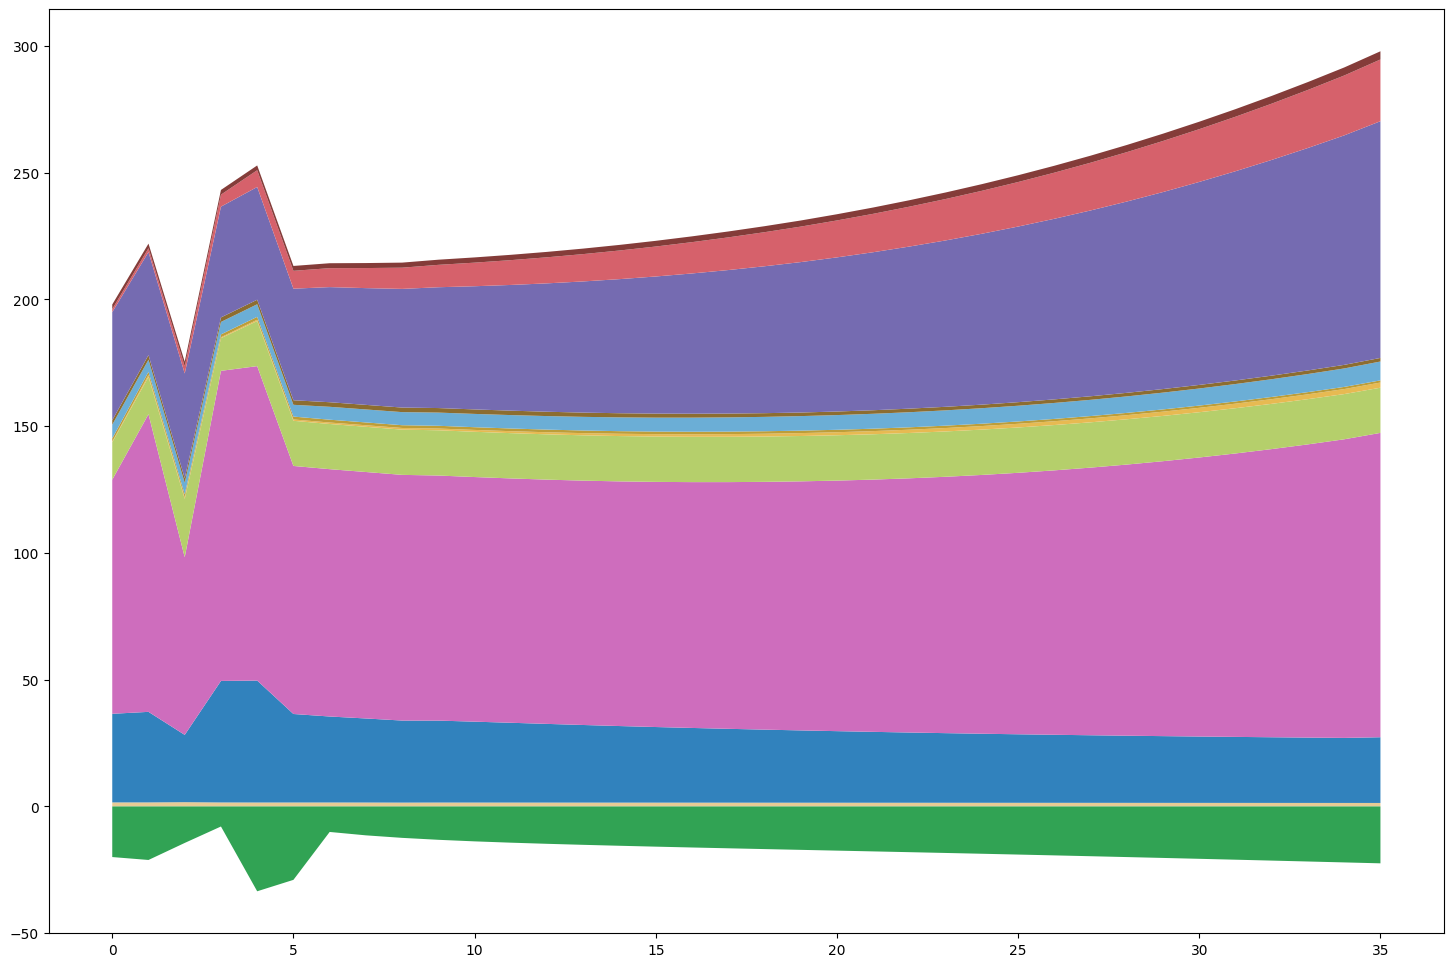

In [142]:
import sisepuede.plotting.plots as spp
df_in = df_inputs_base_la.drop(columns = [regions.key])

df_out = ssp.models.project(
    df_in,
    include_electricity_in_energy = False,
    #models_run = ["af", "ce", "ip", ""]
)

spp.plot_emissions_stack(df_out, matt, )

In [213]:
modvar = matt.get_variable(ssp.models.model_enerprod.modvar_entc_max_elec_prod_increase_for_msp)
modvar

ModelVariable: Maximum Production Increase Fraction to Satisfy MinShareProduction Electricity
Fields:
	frac_entc_max_elec_production_increase_to_satisfy_msp_pp_biogas
	frac_entc_max_elec_production_increase_to_satisfy_msp_pp_biomass
	frac_entc_max_elec_production_increase_to_satisfy_msp_pp_coal
	frac_entc_max_elec_production_increase_to_satisfy_msp_pp_coal_ccs
	frac_entc_max_elec_production_increase_to_satisfy_msp_pp_gas
	frac_entc_max_elec_production_increase_to_satisfy_msp_pp_gas_ccs
	frac_entc_max_elec_production_increase_to_satisfy_msp_pp_geothermal
	frac_entc_max_elec_production_increase_to_satisfy_msp_pp_hydropower
	frac_entc_max_elec_production_increase_to_satisfy_msp_pp_nuclear
	frac_entc_max_elec_production_increase_to_satisfy_msp_pp_ocean
	frac_entc_max_elec_production_increase_to_satisfy_msp_pp_oil
	frac_entc_max_elec_production_increase_to_satisfy_msp_pp_solar
	frac_entc_max_elec_production_increase_to_satisfy_msp_pp_waste_incineration
	frac_entc_max_elec_production_increas

In [232]:

df.to_csv(
    pathlib.Path(examples.file_struct.dir_ref_examples).joinpath("input_data_frame.csv"),
    encoding = "UTF-8",
    index = None,
)

### START TROUBLESHOOTING

2025-08-06 13:36:21,186 - INFO - Running AFOLU model
2025-08-06 13:36:21,186 - INFO - Running AFOLU model
2025-08-06 13:36:21,481 - INFO - AFOLU model run successfully completed
2025-08-06 13:36:21,481 - INFO - AFOLU model run successfully completed
2025-08-06 13:36:21,481 - INFO - Running CircularEconomy model
2025-08-06 13:36:21,481 - INFO - Running CircularEconomy model
2025-08-06 13:36:21,519 - INFO - CircularEconomy model run successfully completed
2025-08-06 13:36:21,519 - INFO - CircularEconomy model run successfully completed
2025-08-06 13:36:21,520 - INFO - Running IPPU model
2025-08-06 13:36:21,520 - INFO - Running IPPU model
2025-08-06 13:36:21,567 - INFO - IPPU model run successfully completed
2025-08-06 13:36:21,567 - INFO - IPPU model run successfully completed
2025-08-06 13:36:21,568 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-06 13:36:21,568 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-08-06 1

2025-06-Aug 13:36:22.346 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.
2025-06-Aug 13:51:33.656 Solver did not find a solution for model. No results will be saved to database.
2025-06-Aug 13:51:33.663 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-06 13:51:33,672 - ERROR - Error running EnergyProduction model: 'NoneType' object is not subscriptable
2025-08-06 13:51:33,672 - ERROR - Error running EnergyProduction model: 'NoneType' object is not subscriptable
2025-08-06 13:51:33,676 - INFO - Running Energy (Fugitive Emissions)
2025-08-06 13:51:33,676 - INFO - Running Energy (Fugitive Emissions)
2025-08-06 13:51:33,694 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-08-06 13:51:33,694 - ERROR - Error running Fugitive Emissions from Energy model: 'NoneType' object has no attribute 'to_numpy'
2025-08-06 13:51:33,694 - INFO - Appending Socioeconomic outputs
2025-08-06 13:51:33,694 - INFO - Appending Socioeconomic outputs
2025-08-06 13:51:33,700 - INFO - Socioeconomi

(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

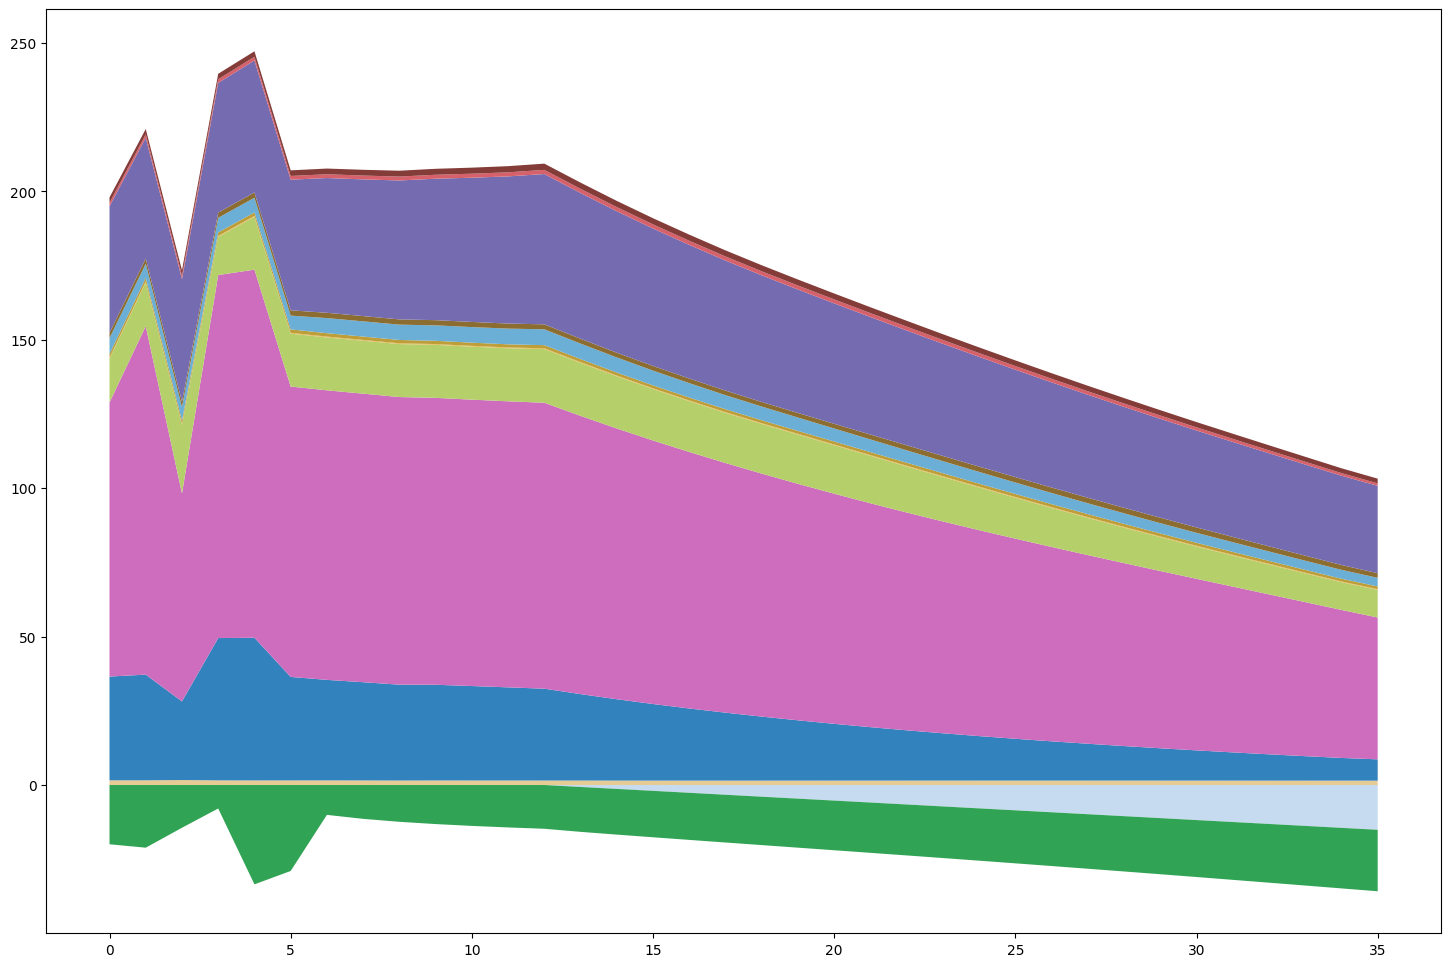

In [205]:
df_in_test = ssp.generate_scenario_database_from_primary_key(df_out[ssp.key_primary].unique()[2])
df_in_test = df_in_test.get("louisiana")
df_out_test = ssp.models.project(
    df_in_test,
    include_electricity_in_energy = True,
)

spp.plot_emissions_stack(df_out_test, matt, )

<Axes: >

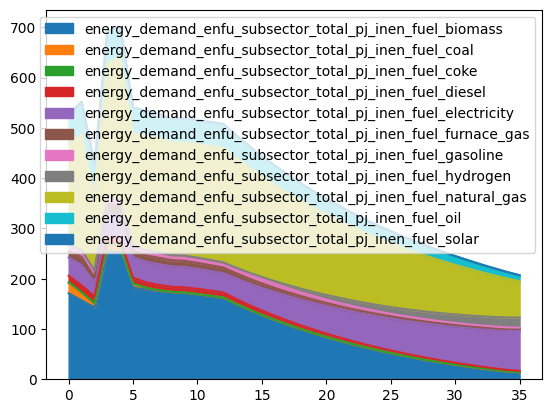

In [203]:
df_test = df_out_test
fields = [
    x for x in df_test.columns 
    if True
    and x.startswith("energy_demand_enfu_subsector_total_pj") # frac_trns_fuelmix
    and ("inen" in x)
    #and ("recycled" rnot in x)
]


(
    df_test[fields]
    .drop(columns = [x for x in fields if df_test[x].max() == 0])
    .plot
    .area()
)#sum(axis = 1)


In [534]:
dict_scens = {
    # we exclude future because we will run across all futures
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: [0, 6004, 6005],
}


ssp.project_scenarios(
    dict_scens,
    check_results = False,
    save_inputs = True,
)


2025-08-13 02:26:34,878 - INFO - 
***	STARTING REGION louisiana	***

2025-08-13 02:26:34,878 - INFO - 
***	STARTING REGION louisiana	***

2025-08-13 02:26:35,844 - INFO - Trying run primary_id = 0 in region louisiana
2025-08-13 02:26:35,844 - INFO - Trying run primary_id = 0 in region louisiana
2025-08-13 02:26:35,844 - INFO - Running AFOLU model
2025-08-13 02:26:35,844 - INFO - Running AFOLU model
2025-08-13 02:26:36,108 - INFO - AFOLU model run successfully completed
2025-08-13 02:26:36,108 - INFO - AFOLU model run successfully completed
2025-08-13 02:26:36,108 - INFO - Running CircularEconomy model
2025-08-13 02:26:36,108 - INFO - Running CircularEconomy model
2025-08-13 02:26:36,136 - INFO - CircularEconomy model run successfully completed
2025-08-13 02:26:36,136 - INFO - CircularEconomy model run successfully completed
2025-08-13 02:26:36,136 - INFO - Running IPPU model
2025-08-13 02:26:36,136 - INFO - Running IPPU model
2025-08-13 02:26:36,179 - INFO - IPPU model run successfully

2025-13-Aug 02:26:36.274 Opened SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-13-Aug 02:26:36.287 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-13-Aug 02:26:36.904 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-13 02:27:20,143 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-13 02:27:20,143 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-13 02:27:20,176 - INFO - EnergyProduction model run successfully completed
2025-08-13 02:27:20,176 - INFO - EnergyProduction model run successfully completed
2025-08-13 02:27:20,177 - INFO - Running Energy (Fugitive Emissions)
2025-08-13 02:27:20,177 - INFO - Running Energy (Fugitive Emissions)
2025-08-13 02:27:20,201 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-13 02:27:20,201 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-13 02:27:20,201 - INFO - Appending Socioeconomic outputs
2025-08-13 02:27:20,201 - INFO - Appending Socioec

2025-13-Aug 02:27:20.009 Finished modeling scenario.


2025-08-13 02:27:20,229 - INFO - Trying run primary_id = 70070 in region louisiana
2025-08-13 02:27:20,229 - INFO - Trying run primary_id = 70070 in region louisiana
2025-08-13 02:27:20,229 - INFO - Running AFOLU model
2025-08-13 02:27:20,229 - INFO - Running AFOLU model
2025-08-13 02:27:20,504 - INFO - AFOLU model run successfully completed
2025-08-13 02:27:20,504 - INFO - AFOLU model run successfully completed
2025-08-13 02:27:20,504 - INFO - Running CircularEconomy model
2025-08-13 02:27:20,504 - INFO - Running CircularEconomy model
2025-08-13 02:27:20,529 - INFO - CircularEconomy model run successfully completed
2025-08-13 02:27:20,529 - INFO - CircularEconomy model run successfully completed
2025-08-13 02:27:20,530 - INFO - Running IPPU model
2025-08-13 02:27:20,530 - INFO - Running IPPU model
2025-08-13 02:27:20,572 - INFO - IPPU model run successfully completed
2025-08-13 02:27:20,572 - INFO - IPPU model run successfully completed
2025-08-13 02:27:20,573 - INFO - Running Energy 

2025-13-Aug 02:27:21.287 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-13 02:28:17,196 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-13 02:28:17,196 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-13 02:28:17,228 - INFO - EnergyProduction model run successfully completed
2025-08-13 02:28:17,228 - INFO - EnergyProduction model run successfully completed
2025-08-13 02:28:17,229 - INFO - Running Energy (Fugitive Emissions)
2025-08-13 02:28:17,229 - INFO - Running Energy (Fugitive Emissions)
2025-08-13 02:28:17,255 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-13 02:28:17,255 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-13 02:28:17,255 - INFO - Appending Socioeconomic outputs
2025-08-13 02:28:17,255 - INFO - Appending Socioec

2025-13-Aug 02:28:17.068 Finished modeling scenario.


2025-08-13 02:28:17,278 - INFO - Trying run primary_id = 71071 in region louisiana
2025-08-13 02:28:17,278 - INFO - Trying run primary_id = 71071 in region louisiana
2025-08-13 02:28:17,278 - INFO - Running AFOLU model
2025-08-13 02:28:17,278 - INFO - Running AFOLU model
2025-08-13 02:28:17,572 - INFO - AFOLU model run successfully completed
2025-08-13 02:28:17,572 - INFO - AFOLU model run successfully completed
2025-08-13 02:28:17,573 - INFO - Running CircularEconomy model
2025-08-13 02:28:17,573 - INFO - Running CircularEconomy model
2025-08-13 02:28:17,601 - INFO - CircularEconomy model run successfully completed
2025-08-13 02:28:17,601 - INFO - CircularEconomy model run successfully completed
2025-08-13 02:28:17,601 - INFO - Running IPPU model
2025-08-13 02:28:17,601 - INFO - Running IPPU model
2025-08-13 02:28:17,647 - INFO - IPPU model run successfully completed
2025-08-13 02:28:17,647 - INFO - IPPU model run successfully completed
2025-08-13 02:28:17,648 - INFO - Running Energy 

2025-13-Aug 02:28:19.360 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112
2025-08-13 02:29:36,472 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-13 02:29:36,472 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-08-13 02:29:36,488 - INFO - EnergyProduction model run successfully completed
2025-08-13 02:29:36,488 - INFO - EnergyProduction model run successfully completed
2025-08-13 02:29:36,489 - INFO - Running Energy (Fugitive Emissions)
2025-08-13 02:29:36,489 - INFO - Running Energy (Fugitive Emissions)
2025-08-13 02:29:36,510 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-13 02:29:36,510 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-08-13 02:29:36,511 - INFO - Appending Socioeconomic outputs
2025-08-13 02:29:36,511 - INFO - Appending Socioec

2025-13-Aug 02:29:36.364 Finished modeling scenario.


2025-08-13 02:29:36,599 - INFO - Table MODEL_OUTPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-08-13T02;26;01.977344/sisepuede_run_2025-08-13T02;26;01.977344_output_database/MODEL_OUTPUT.csv.
2025-08-13 02:29:36,599 - INFO - Table MODEL_OUTPUT successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-08-13T02;26;01.977344/sisepuede_run_2025-08-13T02;26;01.977344_output_database/MODEL_OUTPUT.csv.
2025-08-13 02:29:36,601 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-08-13T02;26;01.977344/sisepuede_run_2025-08-13T02;26;01.977344_output_database/ATTRIBUTE_PRIMARY.csv.
2025-08-13 02:29:36,601 - INFO - Table ATTRIBUTE_PRIMARY successfully written to /Users/usuario/git/sisepuede/sisepuede/out/sisepuede_run_2025-08-13T02;26;01.977344/sisepuede_run_2025-08-13T02;26;01.977344_output_database/ATTRIBUTE_PRIMARY.csv.
2025-08-13 02:29:36,714 - INFO - Table M

{'louisiana': [0, 70070, 71071]}

In [540]:
ssp.generate_summary_files(None, export = True, )

{'WIDE_INPUTS_OUTPUTS':      primary_id     region  time_period  area_agrc_crops_bevs_and_spices  \
 0             0  louisiana            0                              0.0   
 1             0  louisiana            1                              0.0   
 2             0  louisiana            2                              0.0   
 3             0  louisiana            3                              0.0   
 4             0  louisiana            4                              0.0   
 ..          ...        ...          ...                              ...   
 103       71071  louisiana           31                              0.0   
 104       71071  louisiana           32                              0.0   
 105       71071  louisiana           33                              0.0   
 106       71071  louisiana           34                              0.0   
 107       71071  louisiana           35                              0.0   
 
      area_agrc_crops_cereals  area_agrc_crops_fibe

In [536]:
df_out = ssp.read_output(None)

In [442]:
df_out[
    df_out["time_period"].isin([35])
][
    [x for x in df_out.columns if x.startswith("emission_co2e_subsector_tot")]
]

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,emission_co2e_subsector_total_scoe,emission_co2e_subsector_total_soil,emission_co2e_subsector_total_trns,emission_co2e_subsector_total_trww,emission_co2e_subsector_total_waso
35,1.576809,-31.089497,80.767204,7.404707,-22.527192,0.679743,21.495484,7.438286,0.089316,0.514222,0.000000,2.256704,15.495220,0.889505,3.282973
71,2.128777,-17.023380,120.445794,25.319083,-23.287010,13.702255,73.212955,16.029264,0.203121,0.987656,5.483687,2.553636,58.084161,1.836110,3.584911
107,1.853280,-19.641490,179.868515,43.215612,-23.831889,7.286136,58.038753,16.325884,0.164047,0.736770,4.854217,2.523822,41.758730,1.834024,3.353141
143,1.726427,-18.146947,138.352376,28.448857,-23.838496,1.222332,31.732072,14.968224,0.149093,0.742440,1.833621,2.353145,63.585650,1.515708,3.500505


(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

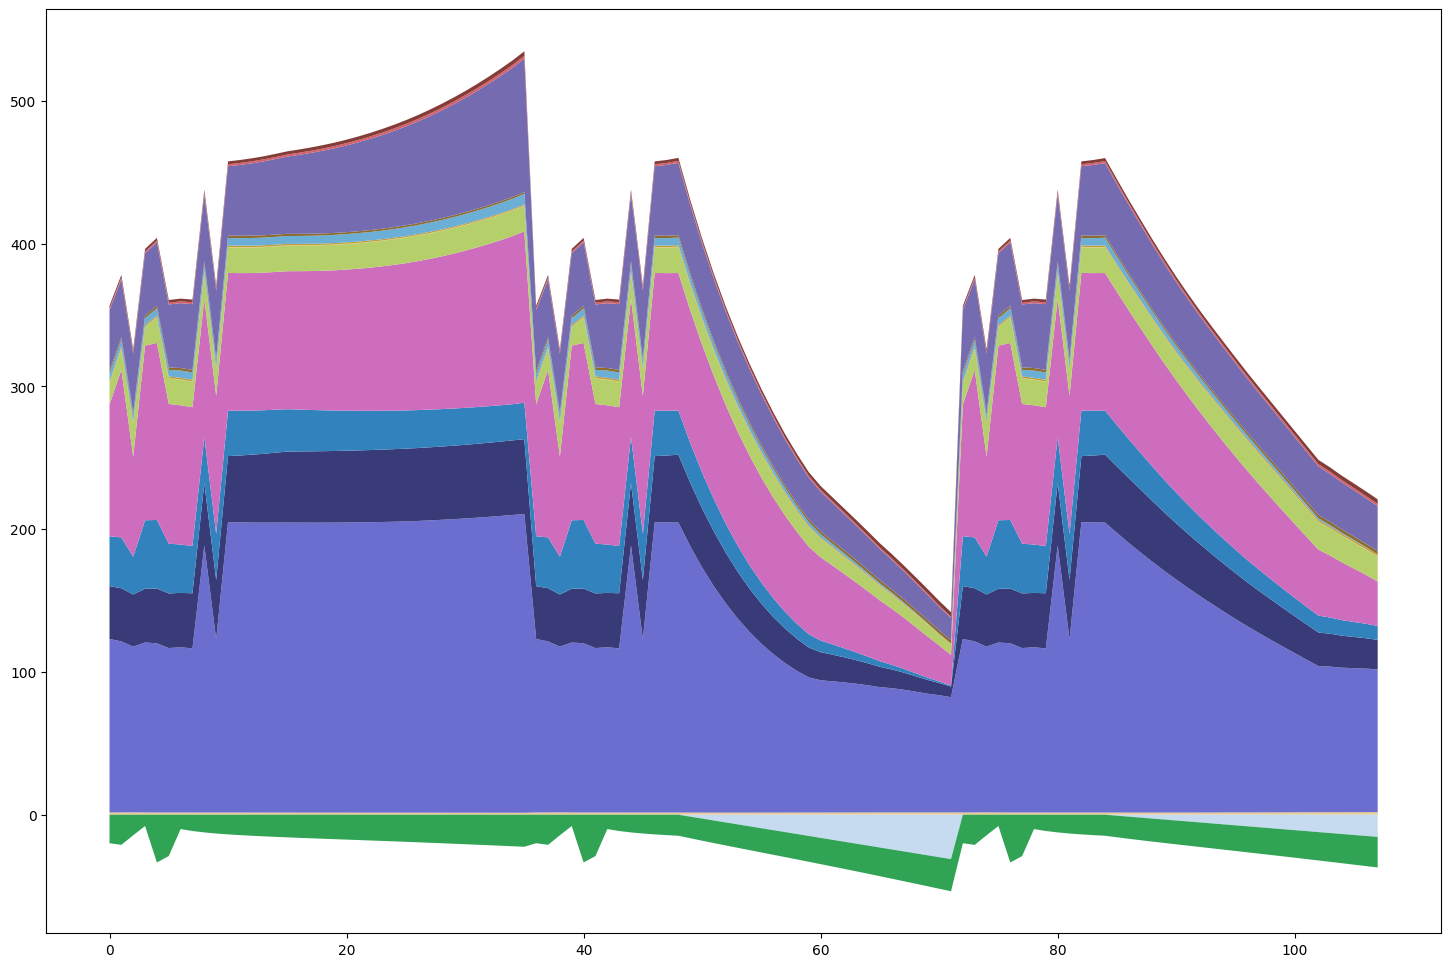

In [537]:
spp.plot_emissions_stack(df_out, matt)

# Finally, we can export a summary file

In [ ]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)
all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)


df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)





# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    ssp.database.db.read_table(tab).to_csv(
        os.path.join(dir_pkg, f"{tab}.csv"),
        index = None,
        encoding = "UTF-8"
    )


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)